# Vehicle Detector

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import os
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.ndimage.measurements import label
from scipy.stats import uniform as sp_uniform
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print("done")

done


# read image

In [2]:


vehicles_dir = './vehicles/'
vehicles_image_types = os.listdir(vehicles_dir)
cars = []
for imtype in vehicles_image_types:
    cars.extend(glob.glob(vehicles_dir+imtype+'/*'))
print('car image types: ', vehicles_image_types)
print('number of cars: ', len(cars))
print()

non_vehicles_dir = './non-vehicles/'
non_vehicles_image_types = os.listdir(non_vehicles_dir)
notcars = []
for imtype in non_vehicles_image_types:
    notcars.extend(glob.glob(non_vehicles_dir+imtype+'/*'))
print('not car image types: ', non_vehicles_image_types)
print('number of not cars: ', len(notcars))
print()

car image types:  ['GTI_MiddleClose', 'GTI_Right', 'GTI_Far', 'KITTI_extracted', 'GTI_Left']
number of cars:  8792

not car image types:  ['GTI', 'Extras']
number of not cars:  8968



## Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [3]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features



In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     hist_bins=16, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        img_features = []
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
#         print('spatial feature shape: ', spatial_features.shape)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
#         print('hist feature shape: ', hist_features.shape)
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)
#         print('hog features shape: ', hog_features.shape)
#         print('img features shape: ', np.concatenate(img_features).shape)
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    if vis == True:
        return features, hog_image
    else:
        return features

In [7]:
def visualize(fig, rows,cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Set Hyper Para

In [8]:
# train samples 
color_space = 'YCrCb'    # RGB, HSV, LUV, HLS YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'         # 0, 1, 2, 'All'
spatial_size = (16, 16)
hist_bins = 16



ystart = 400
ystop = 656
scale = 1.5

## Extract featcures

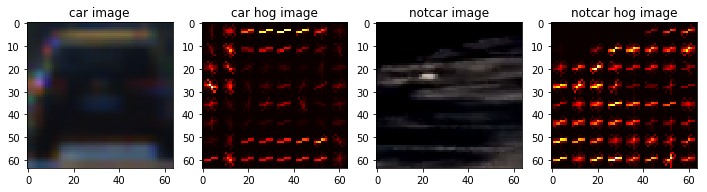

In [9]:
# Extract featcures

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

car_features, car_hog_image = extract_features([cars[car_ind]], cspace=color_space, orient=orient, 
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                               hog_channel=2, hist_bins=hist_bins, vis=True)
notcar_features, notcar_hog_image = extract_features([notcars[notcar_ind]], cspace=color_space, orient=orient, 
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                               hog_channel=2, hist_bins=hist_bins, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car hog image', 'notcar image', 'notcar hog image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)
    


## train samples

In [10]:

t=time.time()
# random_idxs = np.random.randint(0, len(cars), n_samples)
# test_cars = np.array(cars)[random_idxs]
# test_notcars = np.array(notcars)[random_idxs]
test_cars = cars
test_notcars = notcars

car_features = extract_features(test_cars, cspace=color_space, orient=orient, 
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                               hog_channel=hog_channel, hist_bins=hist_bins)
notcar_features = extract_features(test_notcars, cspace=color_space, orient=orient, 
                                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                               hog_channel=hog_channel, hist_bins=hist_bins)
print(time.time()-t, ' seconds to cal features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# print(np.min(X))
# print(np.max(X))

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size = 0.1)

print('orientations: ', orient)
print('pixels per cell: ', pix_per_cell)
print('cells per block: ', cell_per_block)
print('histogram bins: ', hist_bins)
print('spatial sampling: ', spatial_size)
print('feature vector length: ', len(X_train[0]))

svc = LinearSVC()
t= time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'seconds to train')
print('accuracy: ', round(svc.score(X_test, y_test), 4))


204.62512183189392  seconds to cal features
orientations:  9
pixels per cell:  8
cells per block:  2
histogram bins:  16
spatial sampling:  (16, 16)
feature vector length:  6108
21.97 seconds to train
accuracy:  0.9842


## random Search

In [11]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [12]:
n_iter_search = 5
n_samples = 500

svc = SVC()
# param_dist = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':sp_uniform(0.001, 10), 'gamma':sp_uniform(0.001, 10)}
param_dist = {'kernel':['linear', 'rbf'], 'C':scipy.stats.expon(scale=100), 'gamma':scipy.stats.expon(scale=.1)}

t= time.time()
random_search  = RandomizedSearchCV(svc,param_distributions=param_dist,n_iter=n_iter_search)
random_search.fit(X_train[:n_samples], y_train[:n_samples])

print(round(time.time()-t, 2), 'seconds to search')
report(random_search.cv_results_)

8.24 seconds to search
Model with rank: 1
Mean validation score: 0.962 (std: 0.020)
Parameters: {'C': 41.22636279188189, 'kernel': 'linear', 'gamma': 0.016515047221277546}

Model with rank: 1
Mean validation score: 0.962 (std: 0.020)
Parameters: {'C': 30.384154035088883, 'kernel': 'linear', 'gamma': 0.099814564522647919}

Model with rank: 1
Mean validation score: 0.962 (std: 0.020)
Parameters: {'C': 27.620384011480731, 'kernel': 'linear', 'gamma': 0.15028493704850682}

Model with rank: 1
Mean validation score: 0.962 (std: 0.020)
Parameters: {'C': 26.797588963149582, 'kernel': 'linear', 'gamma': 0.020968456928524924}

Model with rank: 1
Mean validation score: 0.962 (std: 0.020)
Parameters: {'C': 14.326754576163101, 'kernel': 'linear', 'gamma': 0.030354417704653816}



In [13]:
svc = SVC(C = random_search.best_params_['C'] , 
          kernel = random_search.best_params_['kernel'], 
          gamma=random_search.best_params_['gamma'])
t= time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'seconds to train')
print('accuracy: ', round(svc.score(X_test, y_test), 4))

130.7 seconds to train
accuracy:  0.9882


## seach window

In [14]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [215]:
# img = mpimg.imread('./test_images/test1.jpg')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, cells_per_step, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    find_cars
#     draw_img = np.copy(img)
#     heatmap = np.zeros_like(img[:,:,0])
    bbox_list = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HSV')
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
#     cells_per_step = 4  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
#             print('hog shape: ', hog_features.shape)
#             print('spatial shape: ', spatial_features.shape)
#             print('hist shape: ', hist_features.shape)
            
            # Scale features and make a prediction
            combine_features = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(combine_features.reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            test_confidence = svc.decision_function(test_features)
            
            
            if test_prediction == 1 and test_confidence > 0.5:
#             if test_prediction == 1 and test_confidence > 1:
#             if test_prediction == 1:
                
#                 test_confidence = svc.decision_function(test_features)
#                 print('test_confidence: ', test_confidence)
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                left_top = (xbox_left, ytop_draw+ystart)
                right_down = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
               
                # cv2.rectangle(draw_img,left_top,right_down,(0,0,255),6)
                bbox_list.append((left_top, right_down))
                
#     return draw_img, bbox_list
    return bbox_list
    
    print("done")

In [204]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, 
                      (bbox[0][0],bbox[0][1]), 
                      (bbox[1][0],bbox[1][1]), 
                      color, 
                      thick)
    return imcopy

In [205]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [52]:
# bbox_list = find_cars(img, ystart, ystop, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# bbox_list2 = find_cars(img, ystart, ystop, 2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# bbox_all = np.vstack((bbox_list,bbox_list2))

# print(np.array(bbox_list).shape)
# print(np.array(bbox_list2).shape)
# print(bbox_all.shape)

### draw boxes

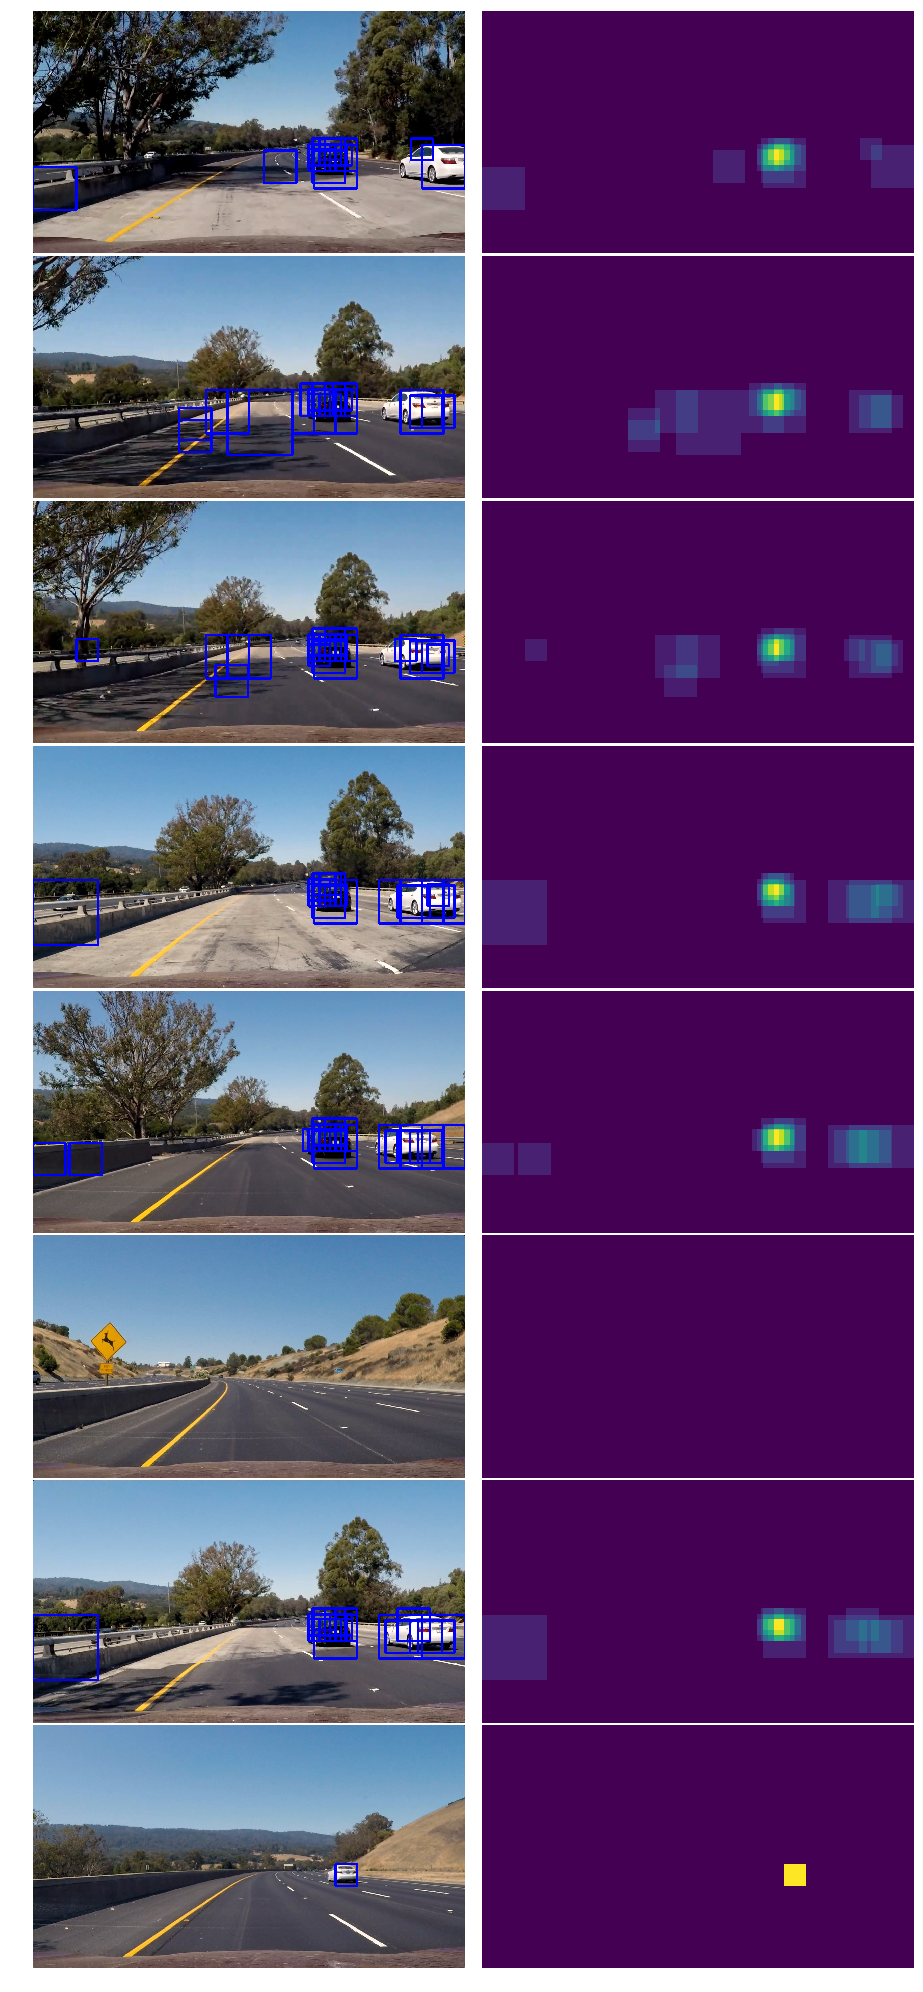

In [225]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(8, 2, figsize=(16,36))
fig.subplots_adjust(hspace = .01, wspace=.01)
axs = axs.ravel()

for i, im in enumerate(test_images):
    
    o_img = mpimg.imread(im)
    bbox_all = find_cars(o_img, 380, 500, 2, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_all = np.array(bbox_all)
    
    search_paras = [
#         [400, 480, 1],
        [380, 600, 3, 1.5],
        [400, 660, 4, 2],
        [400, 660, 4, 3]
        
    ]
    
#     for scale in [1.5, 2]:
    for para in search_paras:
        bbox_list = find_cars(o_img, para[0], para[1], para[2], para[3], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = np.array(bbox_list)
        if len(bbox_list)>0 and len(bbox_all)>0:
            bbox_all = np.vstack((bbox_all, bbox_list))
    
#     o_img = mpimg.imread(im)
    box_img = draw_boxes(o_img,bbox_all)
    heat_img = add_heat(np.zeros_like(o_img[:,:,0]), bbox_all)
    
    axs[i*2].imshow(box_img)
    axs[i*2].axis('off')
    axs[i*2+1].imshow(heat_img)
    axs[i*2+1].axis('off')



# fig = plt.figure(figsize=(12,6))
# plt.subplot(1, 2, 1)
# plt.imshow(box_img)
# plt.title('Car Positions')
# plt.subplot(1, 2, 2)
# plt.imshow(heat_img, cmap='hot')
# plt.title('Heat Map')
# # fig.tight_layout()

In [218]:
def threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

0 cars found


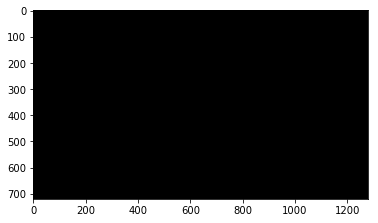

In [27]:
# labels = label(heat_img)label

heat_img = threshold(heat_img, 5)
labels = label(heat_img)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

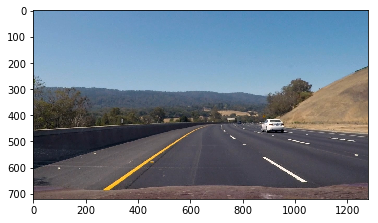

In [34]:

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in the last image above
image = o_img
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

In [226]:
def find_pipe(img):
    bbox_all = find_cars(img, 380, 500, 2, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_all = np.array(bbox_all)
    
    search_paras = [
#         [400, 480, 1],
        [380, 600, 3, 1.5],
        [400, 660, 4, 2],
        [400, 660, 4, 3]
        
    ]
    
#     for scale in [1.5, 2]:
    for para in search_paras:
        bbox_list = find_cars(img, para[0], para[1], para[2], para[3], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bbox_list = np.array(bbox_list)
        if len(bbox_list)>0 and len(bbox_all)>0:
            bbox_all = np.vstack((bbox_all, bbox_list))
    
    global previous_detections
    previous_detections.append(bbox_all)
    previous_detections = previous_detections[-20:]
    
    heat_img = add_heat(np.zeros_like(img[:,:,0]), bbox_all)
#     plt.imshow(heat_img, cmap='hot')
#     plt.show()
    for bbox_list in previous_detections:
        heat_img = add_heat(heat_img, bbox_list)

    heat_img = threshold(heat_img, 20)
#     heat_img = threshold(heat_img, 6)
    labels = label(heat_img)
#     plt.imshow(labels[0], cmap='gray')
    result = draw_labeled_bboxes(np.copy(img), labels)
    return result

In [198]:
# previous_detections = []

# pipe_img = find_pipe(o_img)
# plt.imshow(pipe_img)

In [ ]:
# previous_detections = []
# test_images = glob.glob('./test_images/test*.jpg')

# fig, axs = plt.subplots(4, 2, figsize=(16,18))
# fig.subplots_adjust(hspace = .01, wspace=.01)
# axs = axs.ravel()

# for i, im in enumerate(test_images):
#     o_img = mpimg.imread(im)
#     pipe_img = find_pipe(o_img)
    
#     axs[i].imshow(pipe_img)
#     axs[i].axis('off')


In [228]:
previous_detections = []

pre_start = 14
pre_end = pre_start+1

real_start = pre_end
real_end = 50

test_output = 'pre.mp4'
# clip = VideoFileClip("project_video.mp4")
clip = VideoFileClip("project_video.mp4").subclip(pre_start,pre_end)
#     clip = VideoFileClip("test_video.mp4")
clip = clip.to_RGB()
test_clip = clip.fl_image(find_pipe)
test_clip.write_videofile(test_output, audio=False)
test_clip.reader.close()
test_clip.audio.reader.close_proc()

for i in range(real_start, real_end, 5):
    start = i
    end = i+5
    
    test_output = str(start) + '-' + str(end) + '.mp4'
    # clip = VideoFileClip("project_video.mp4")
    clip = VideoFileClip("project_video.mp4").subclip(start,end)
#     clip = VideoFileClip("test_video.mp4")
    clip = clip.to_RGB()
    test_clip = clip.fl_image(find_pipe)
    test_clip.write_videofile(test_output, audio=False)

    test_clip.reader.close()
    test_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video pre.mp4
[MoviePy] Writing video pre.mp4


 96%|█████████▌| 25/26 [03:42<00:08,  8.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: pre.mp4 

[MoviePy] >>>> Building video 15-20.mp4
[MoviePy] Writing video 15-20.mp4


 99%|█████████▉| 125/126 [18:29<00:08,  8.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 15-20.mp4 

[MoviePy] >>>> Building video 20-25.mp4
[MoviePy] Writing video 20-25.mp4


 99%|█████████▉| 125/126 [18:30<00:08,  8.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 20-25.mp4 

[MoviePy] >>>> Building video 25-30.mp4
[MoviePy] Writing video 25-30.mp4


 99%|█████████▉| 125/126 [18:31<00:08,  8.86s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 25-30.mp4 

[MoviePy] >>>> Building video 30-35.mp4
[MoviePy] Writing video 30-35.mp4


 99%|█████████▉| 125/126 [18:33<00:08,  8.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 30-35.mp4 

[MoviePy] >>>> Building video 35-40.mp4
[MoviePy] Writing video 35-40.mp4


 99%|█████████▉| 125/126 [18:33<00:08,  8.93s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 35-40.mp4 

[MoviePy] >>>> Building video 40-45.mp4
[MoviePy] Writing video 40-45.mp4


 99%|█████████▉| 125/126 [18:33<00:08,  8.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 40-45.mp4 

[MoviePy] >>>> Building video 45-50.mp4
[MoviePy] Writing video 45-50.mp4


 99%|█████████▉| 125/126 [18:31<00:08,  8.87s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 45-50.mp4 



In [229]:
previous_detections = []

test_output = 'result.mp4'
# clip = VideoFileClip("project_video.mp4")
# clip = VideoFileClip("project_video.mp4").subclip(14,16)
clip = VideoFileClip("test_video.mp4")
clip = clip.to_RGB()
test_clip = clip.fl_image(find_pipe)
test_clip.write_videofile(test_output, audio=False)

test_clip.reader.close()
test_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 97%|█████████▋| 38/39 [05:37<00:08,  8.90s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [230]:
HTML("""
<video width="480" height="270" controls>
    <source src="{0}">
</video>
""".format(test_output))